# _A MIXTURE OF FIVE_

In [1]:
import numpy as np
import math
import pandas as pd
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as rand
import scipy.stats as stats
import scipy.misc as misc
import scipy.special as special
from collections import Counter

## 1. Reproducing Wiggins' result

_I credit the code below to MCB112's section 6 notes and homework hint code (for producing the visual), with changes to the code to account for the fact that there are now 2 dimensions instead of 1, as well as updated the docstring for the methods to be in line with the updated methods._

We reproduce Wiggins' result using the _k_-means clustering procedure. I repeat the _k_-means algorithm 20 times and obtain the best cluster estimates out of those iterations -- "best" being defined as the cluster estimates that give us the minimum total squared distance from each cell to the cluster means. In each iteration, centroids/cluster estimates are chosen in one of 3 ways:

1. By taking the minimum and maximum read counts for both Caraway and Kiwi genes, and then randomly sample 5 numbers in between the minimums and maximums for each gene, evenly split into 10000 intervals.
2. By taking 5 random data points (or cells) from our data, and have them serve as our initial estimates.
3. By randomly assigning all the cells to a cluster, and then calculating the mean estimate of the cluster by taking the mean of all the Caraway and Kiwi mapped counts of the cells assigned to the clusters.

A review of the _k_-means algorithm is as follows: Using the ```assignment``` method given to us in section notes, for every cell, we find the cell's closest cluster by calculating the minimum Euclidean distance $d_i$ from the $i^{th}$ cell to each of the five cluster estimates. The Euclidean distance can be calculated by:

$$d_i = \sqrt{(x_{i0} - q_0)^2 + (x_{i1} - q_1)^2}$$

where $x_{i0}$ and $x_{i1}$ represent the $i^{th}$ cell's Caraway read counts and Kiwi counts respectively and $q_{0}$ and $q_{1}$ represent the cluster's Caraway read counts and Kiwi counts respectively.
 
We assign the cell to the cluster which yields the minimum Euclidean distance from that cell. Any cluster that does not have any cell assigned to it will have the cell that is furthest away from its assigned cluster be assigned to that cluster (using the ```assign_empty``` method), as the most outlier cell will theoretically be more likely to not belong in its cluster.

After assigning all the cells to their clusters, we ```update``` the five clusters that we have by taking the average mean counts for Caraway and Kiwi of all the cells in their respective clusters.

We repeat these steps until there is no difference from the previous cluster estimate to our current cluster estimate.

###### Q: What is a good statistic for choosing the "best" solution for K-means?

As previously mentioned before, a good statistic for choosing the "best" solution for K-means is the smallest total squared distance generated of all 20 iterations of K-means. Furthermore, as there are multiple ways of initializing our estimates, we take the minimum total squared distance of the overall K-means algorithm from the 3 methods.

##### METHODS TO PERFORM THE K-MEANS CLUSTERING ALGORITHM

In [4]:
# CREDIT: THE SCRIPT WIGGINS USED TO READ IN THE DATA
def read_data(infile):
    '''
    read_data(infile)
    Read Lestrade's input file, w06-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( (int(fields[2]), int(fields[3])))  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

In [5]:
def calc_distance(point, center):
    '''Finds the Euclidean distance from a point and a center.

    Parameters
    ----------
    point    : list or 1D array
               list of coordinates
    center   : list or 1D array
               list of coordinates
               
    Returns
    ----------
    dist     : float
               Euclidean distance between point and center. 
    '''
    if len(point) != len(center):
        raise Exception ('Dimensions do not match.')
    
    dist = 0
    
    for i in len(point):
        dist += (point[i] - center[i]) ** 2
    
    dist = math.sqrt(dist)
    return dist
    
    
def assignment(data,centers):  
    '''
    Return current cluster assigned to each point, as well as the 
    sum of this distances between each point and its assigned cluster
    
    Parameters
    ----------
    data     : list of lists or 2D array
               list of each cell's mapped counts for Caraway and Kiwi genes
    centers  : list of current center estimates for the clusters
       
    Returns
    -------
    clusters : list or 1D array
               list of current cluster assignment for each point
    distance : float
               sum of distances between each point and its assigned cluster center
    '''
    
    # Find minimum Euclidean distance between cell and each cluster center
    distances = [np.min([calc_distance(cell, i) for i in centers]) for cell in data]
    
    # Assign each point to the closest cluster center
    clusters =  [np.argmin([calc_distance(cell, i) for i in centers]) for cell in data]
    
    # Count how many points in each cluster
    c = Counter(clusters)
    
    # Look for empty clusters
    for x in set(range(len(centers))).difference(set(c.keys())):
        clusters,distances =  assign_empty(x,clusters,distances)
    distance = sum(distances)
    
    return clusters, distance

# CREDIT: SECTION NOTES
def assign_empty(c,clusters,distances):
    
    '''
    Assigns the point furthest from its current cluster center to an empty cluster
    Returns an updated cluster list and updatd distances list
    
    Parameters
    ----------
    c        : int
               number of empty cluster   
    clusters : list or 1D array
               list of current cluster assignment for each point
    distances: list or 1D array
               list of current distances between each point and its assigned center
       
    Returns
    -------
    clusters : list or 1D array
               list of current cluster assignment for each cell
    distances: list or 1D array
               list of current distances between each cell and its assigned center
    '''
    
    # find index of point furthest from its assigned center
    max_idx = np.argmax(distances)
    
    # set distances at that index to 0
    distances[max_idx] = 0
    
    # set clusters at that index to empty cluster
    clusters[max_idx] = c
    
    return clusters,distances

# CREDIT: SECTION NOTES
def update(coords, clusters, num_clust):
    
    '''
    Calculates the new cluster centers as an average of the positions of all 
    points included in the cluster.
    
    Parameters
    ----------
    coords   : list or 2D ndarray
               list X-coordinates of all points   
    clusters : list or 1D array
               list of current cluster assignment for each point
    num_clust: int
               number of clusters
       
    Returns
    -------
    centers  : list of lists or 2D array
               list of current estimated center for each cluster
    '''
    coords = np.asarray(coords)
    
    # Find indices of each point assigned to each cluster
    clusters = ([np.where(np.asarray(clusters) == x) for x in range(num_clust)])
    
    # Average position of each point assigned to each cluster
    centers = [np.mean(coords[clusters[x]],0) for x in range(len(clusters))]    

    return centers

In [6]:
# CREDIT: THE SCRIPT WIGGINS USED TO VISUALIZE DATA AFTER K-MEANS CLUSTERING
def visualize_data(data, mu, C):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    plt.show()

Here, I create an overarching k-means method that utilizes the functions from above, and allows the user to choose which initialziation method they want: random points from space, random points from data, or assigning points random clusters and taking the centroids of those clusters.

In [7]:
# GENERAL CUSTOM METHOD THAT USES CODE FROM SECTION TO RUN K-MEANS
# WITH A VARIETY OF INITIALIZATION METHODS
def kmeans(data, init, num_clust, iters):
    '''
    Calculates the hard k-means clustering.
    
    Parameters
    ----------
    data     : list or 2D ndarray
               Coordinates of all points   
    init     : initialization method
               1: random points from space; 
               2: random points from data; 
               3: assigning points random clusters
    num_clust: int
               number of clusters
    iters    : int
               number of iterations
       
    Returns
    -------
    min_dist      : float
                    minimum total squared distance from the iterations
    centers_best  : list of lists or 2D array
                    list of current estimated center for each cluster
    clusters_best : list or 1D array
                    list of current best cluster for each cell
    '''
    # Initialize best clusters
    min_dist = float('inf')
    clusters_best = []
    
    # Min and max data for the coordinates
    min_x, min_y = np.min(data,0)
    max_x, max_y = np.max(data,0)
    
    np.random.seed(0)
    
    # CREDIT: SECTION NOTES
    # Loop on iters
    for i in range(iters):

        # Initialize centroids using random points from space
        if init == 1:
            # Each iteration starts with a random set of centers
            # Centers randomly chosen in between minimum and maximum counts
            x_centers = np.random.choice(np.linspace(min_x,max_x,10000),num_clust)
            y_centers = np.random.choice(np.linspace(min_y,max_y,10000),num_clust)
            centers = np.array(list(zip(x_centers, y_centers)))
        
        # Initialize centroids using random points from data
        elif init == 2:
            # Getting num_clust random indices to get from the data
            idx = np.random.randint(len(data), size=num_clust)
            centers = data[idx,:]
            
        # Initialize centroids by randomly assigning clusters to data and finding means
        else:
            # randomly assigning each data point to a cluster
            rand_clusters = np.random.randint(0, num_clust + 1, size=len(data))
            centers = update(data, rand_clusters, num_clust)
            
        # Start with empty clusters
        clusters_old = []*len(data)
        clusters = [0]* len(data)

        # Iterate until clusters don't change
        while clusters != clusters_old:

            # Update clusters
            clusters_old = clusters

            # New Assignment 
            clusters,distance = assignment(data,centers)        

            # New centers
            centers = update(data, clusters, num_clust)

        # Save clusters and centers if it has minimal summ distance to date
        if distance < min_dist:            
            min_dist = distance
            centers_best = centers
            clusters_best = clusters
            
    return (min_dist, centers_best, clusters_best)

##### PERFORMING THE K-MEANS CLUSTERING ALGORITHM

In [9]:
# actual cell types, data, number of cells, number of genes, number of clusters
ctype, data, num_cells, num_genes, num_clust = read_data('w05-data.tbl')

To choose the best cluster centers, we run the k-means algorithm for 20 iterations 3 times -- once for each initialization method. Out of the three runs of the k-means algorithm, we take the best clusters/centers from the method that produces the smallest total squared distance, which is the ```min_dist``` produced by the ```kmeans``` method implemented above.

In [12]:
# running k-means by initializing random points in space as centroids
kmeans_rspace = kmeans(data, 1, num_clust, 20)

# running k-means by initializing random points in data as centroids
kmeans_rdata = kmeans(data, 2, num_clust, 20)

# running k-means by initializing random clusters to data
kmeans_rclusters = kmeans(data, 3, num_clust, 20)

TypeError: 'int' object is not iterable

In [11]:
min_dists = [kmeans_rspace[0], kmeans_rdata[0], kmeans_rclusters[0]]

if np.argmin(min_dists) == 0:
    min_dist = kmeans_rspace[0]
    centers_best = kmeans_rspace[1]
    clusters_best = kmeans_rspace[2]
elif np.argmin(min_dists) == 1:
    min_dist = kmeans_rdata[0]
    centers_best = kmeans_rdata[1]
    clusters_best = kmeans_rdata[2]
else:
    min_dist = kmeans_rclusters[0]
    centers_best = kmeans_rclusters[1]
    clusters_best = kmeans_rclusters[2]

NameError: name 'kmeans_rspace' is not defined

In [9]:
# the minimum total squared distances from each of the initialization methods
print (min_dists)

[507543.46286257566, 501412.6250450593, 501578.68635579257]


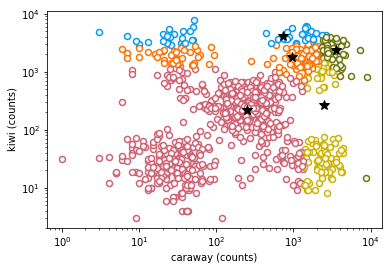

In [10]:
# visualizing the data
visualize_data(data, np.array(centers_best), clusters_best)

In [11]:
print ('The minimum total distance generated is: {}'.format(min_dist))

The minimum total distance generated is: 501412.6250450593


In [12]:
# method to return a dataframe of the fraction of each cluster as well as their mean counts for the genes
def expr_levels(mean_exp, clusters_best):
    values = np.array((list(Counter(sorted(clusters_best)).values())))
    values = np.divide(values, sum(values))
    df = pd.concat([pd.DataFrame(values), pd.DataFrame(mean_exp)],axis=1)
    df.columns = ['fraction', 'Caraway mean count', 'Kiwi mean count']
    return (df)

In [13]:
expr_levels(kmeans_rdata[1], kmeans_rdata[2])

,fraction,Caraway mean count,Kiwi mean count
0,0.128,944.718750,1796.406250
1,0.055,3548.872727,2336.763636
2,0.051,726.235294,4141.666667
3,0.667,252.269865,223.154423
4,0.099,2460.535354,263.313131


### Observations

We can see that of the 3 initialization methods used for the _K_-means algorithm, randomly choosing 5 cells from the data as the cluster estimates as well as randomly assigning the cells to the clusters yields a better minimum total squared distance than randomly choosing 5 points in between the minimum and maximum mapped counts of Caraway and Kiwi genes (at least, for our random seed). However, despite choosing the best minimum total squared distance, we can see that we have generated about the same result Wiggins did before he quit the lab. From the DataFrame generated above, we can confirm that we generated fractions of each cell cluster and their associated Caraway/Kiwi mean counts similar to that of Wiggins' results.

### Q: Why is K-means clustering producing this result, when there are clearly five distinct clusters in the data?

If we look at the ```visualize_data``` method that Wiggins wrote, he plots the points on the log scale. However, we are creating clusters on the raw data, without log transforming the data beforehand. If we plot the points without log-scaling them:

In [13]:
# Splitting up the data from best K-means clustering by cluster
cluster0 = [i for i, x in enumerate(clusters_best) if x == 0]
cluster1 = [i for i, x in enumerate(clusters_best) if x == 1]
cluster2 = [i for i, x in enumerate(clusters_best) if x == 2]
cluster3 = [i for i, x in enumerate(clusters_best) if x == 3]
cluster4 = [i for i, x in enumerate(clusters_best) if x == 4]

data0 = [list(data[i]) for i in cluster0]
data1 = [list(data[i]) for i in cluster1]
data2 = [list(data[i]) for i in cluster2]
data3 = [list(data[i]) for i in cluster3]
data4 = [list(data[i]) for i in cluster4]

x0, y0 = zip(*data0)
x1, y1 = zip(*data1)
x2, y2 = zip(*data2)
x3, y3 = zip(*data3)
x4, y4 = zip(*data4)
x5, y5 = zip(*centers_best)

NameError: name 'clusters_best' is not defined

In [14]:
# Generating scatter plot without log scaling
plt.scatter(x0, y0, edgecolors='xkcd:rose', facecolors='none')
plt.scatter(x1, y1, edgecolors='xkcd:olive', facecolors='none')
plt.scatter(x2, y2, edgecolors='xkcd:azure', facecolors='none')
plt.scatter(x3, y3, edgecolors='xkcd:gold', facecolors='none')
plt.scatter(x4, y4, edgecolors='xkcd:orange', facecolors='none')
plt.scatter(x5, y5, color="black", marker="*", s=50)
plt.xlabel('Caraway counts')
plt.ylabel('Kiwi counts')
plt.show()

NameError: name 'x0' is not defined

We can see that even though there are clear clusters on the log scale scatterplot, the clusters on the real linear axis aren't as obvious, if noticeable at all. However, with the K-means clustering, we had fit the real data to the clusters instead of the log transformed data, giving us the undesirable results that we see above. 

## 2. Mixture negative binomial fitting

_First and foremost, I credit the code below to MCB112's section 6 notes and homework hint code (for producing the visual), with changes to the code to account for the fact that there are now 2 dimensions instead of 1, as well as updated the docstring for the methods to be in line with the updated methods._

For the mixture negative binomial model fitting, we assume that each cell has a probability of belonging to a certain cluster with some mixed coefficient $\pi_q$, where the cluster has gene counts represented by the negative binomial distribution with some fixed disperstion parameter $\phi = 0.3$. In the expectation-maximization algorithm, we calculate the posterior probabilities of each cell coming from each of the five clusters (initially created also by one of the three methods mentioned above) by multiplying the probability of choosing that cluster (from our mixed coefficients) with the PMFs of choosing the gene counts for Caraway and Kiwi from negative binomial distributions. Because we are essentially dealing with two dimensions, one for the Caraway gene and one for the Kiwi gene, each cluster has two negative binomial distributions associated with it -- one for the distribution of Caraway counts and one for the distribution of Kiwi counts. We assume that these two distributions are indepedent of each other.

Doing this for each cluster, this generates the probability of obtaining that cell with the given cluster distribution. To calculate the posterior probabilities, we must normalize each of these probabilites by dividing them by sum of all of these probabilities (this follows from the Law of Total Probability). Whichever cluster has the highest posterior probability of generating that cell will be the cluster that the cell is assigned to. In other words, we calculate for every cluster $q$ and cell $x_{ij}$ with Caraway count $i$ and Kiwi count $j$:

$$P(q \mid x_ij, \mu_q, \phi) = \frac{\pi_q * P(x_i \mid \mu_{qi}, \phi) * P(x_j \mid \mu_{qi}, \phi)}{P(x_{ij})}.$$

This process is known as the Expectation step of the expectation-maximization algorithm.

In the maximization step of the algorithm, we update the cluster centers and mixture coefficients for each cluster. To obtain the new cluster centers, for every cluster $q$, we add up the Caraway counts of each cell multiplied by the posterior probability of the cluster generating that cell, all divided by the posterior probabilities of the cluster generating the cells (analogous to a weighted mean). We do the same for Kiwi counts for each cluster. Thus, for a new $\mu_q$:

$$\mu_q = \left(\frac{\Sigma_{i=0}^{n}x_i*P(q \mid x_{i})}{\Sigma_{i=0}P(q \mid x_{i})}, \frac{\Sigma_{j=0}^{n}x_j*P(q \mid x_{j})}{\Sigma_{j=0}P(q \mid x_{j})}\right).$$

The new mixed coefficient $\pi_q$ for the new cluster $q$ is the average of all the posterior probabilities for $q$.

_Because the PMFs generate can get extremely low and multiplying probabilites together can yield extremely low values, this may result in underflow. Thus, when calculating the PMFs and multiplying probabilities together to achieve posterior probabilities, we do so by adding and subtracting their logs instead._

Lastly, in the last step of the algorithm, we calculate the negative log likelihood for each cell given our generated model. This is done by first: multiplying the mixture coefficient with the negative binomial PMF (again, the dispersion parameter being constant 0.3 in our case) each cell's Caraway count and Kiwi count given every new centroid that we calculated from the maximization step (done by adding their logs) to generate individual log likelihoods of each cell, and second: adding together all the log likelihoods. Lastly, we take the negative of the log likelihood to generate a positive number. In other words, we calculate:

$$\text{Neg Log Likelihood} = -\Sigma_q \Sigma_{x_{ij} \in X} \log(\pi_q) + \log(P(x_{ij} \mid \mu_q) + \log(P(x_{ij} \mid \mu_q)$$

###### Q: What is an appropriate statistic for choosing the "best" fit?

We base our "best" fit statistic on the negative log likelihood generated after every iteration of the expectation-maximization algorithm. In particular, we take the negative log likelihood that is smallest. The intuition behind this is that because we are taking logs of probabilites (which range from 0 to 1), logs of probabilities are negative, and therefore the total sum of these logs will be even more negative. As probabilities get smaller and smaller, log probabilities get more and more negative. Thus the smallest negative log likelihood actually represents the greatest total probability of the models. Furthermore, we take the minimum of the minimum negative log likelihoods from our 3 initialization methods used in the expectation-maximization algorithm to ensure that we are choosing the best initialization method.

##### METHODS TO PERFORM MIXTURE MODELS EXPECTATION MAXIMIZATION

In [32]:
# CREDIT: MCB112 SECTION NOTES
def expectation(coords, mus, phi, mix_coeffs):
    '''
    Return the Posterior Probability of each data point coming from each componenent
    
    Parameters
    ----------
    coords    : list of lists or 2D array: [caraway count, kiwi count] for all cells
    mus       : list of lists or 2D array, list of current caraway/kiwi count estimates for the 5 cells
    phi       : dispersion parameter    
    mix_coeffs: list or 1D array, list of current estimates for mixture coefficients of components
                      
    Returns
    -------
    posts    : 2D array, Posterior probabilities of each component being the
               source of each point.
    clusters : list or 1D array, list of current cluster assignment for each point 
    '''
    
    # Initialze P(q|x)
    Pqx = []
    
    # Loop through points
    for point in coords: 
        # Append pi * P(x|q) in log space
        Pqx.append([np.log(mix_coeffs[i]) +
                    stats.nbinom.logpmf(point[0],1/phi,1/(1+mu[0]*phi)) + 
                    stats.nbinom.logpmf(point[1],1/phi,1/(1+mu[1]*phi)) for i,mu in enumerate(mus)])

    # Normalize
    posts = [x - special.logsumexp(x) for x in Pqx]
    
    # Revert back to linear space
    posts = np.exp(posts)
    
    # Assign clusters based on max posterior probability
    clusters = [np.argmax(post) for post in posts]
    return posts,clusters

def maximization(coords, posts, mix_coeffs):
    '''
    Return the update mu and mixture coefficient for each component
    
    Parameters
    ----------
    coords    : list of lists or 2D array, list of Caraway/Kiwi counts from the cells
    posts     : 2D array, Posterior probabilities of each component being the
                source of each point.
    mix_coeffs: list or 1D array, list of current estimates for mixture coefficients of components
                             
    Returns
    -------
    mus       : list or 1D array, new estimate of component means
    mix_coeffs: list or 1D array, list of current estimates for mixture coefficients of components 
    '''
    
    # calculate the new mean as the posterior weighted average of point positions
    num_mu_car = np.sum([np.multiply(posts[i],x[0]) for i,x in enumerate(coords)],0)    
    num_mu_kiwi = np.sum([np.multiply(posts[i],x[1]) for i,x in enumerate(coords)],0) 
    denom_mu = np.sum(posts,0)
    car_mus = np.divide(num_mu_car,denom_mu)
    kiwi_mus = np.divide(num_mu_kiwi,denom_mu)
    mus = np.array(list(zip(car_mus, kiwi_mus)))
    
    # calculate the new mixture coefficients as the mean of the posteriors
    mix_coeffs = np.divide(np.sum(posts,0),len(coords))    
    
    return mus,mix_coeffs

def negll(coords, mus, phi, mix_coeffs):
    '''
    Return the negative log likelihood of data given the current mixture model
    
    Parameters
    ----------
    coords    : list of lists or 2D array, list of Caraway/Kiwi counts from the cells
    mus       : list of lists or 2D array, list of current caraway/kiwi count estimates for the 5 cells
    phi       : dispersion parameter    
    mix_coeffs: list or 1D array, list of current extiamtes for mixture coefficients of components
                      
    Returns
    -------
    nll       : float, negative log likelihood of data given model
    '''
    
    # Compute the nll as the nbinom logpmf of the data, given mu and sigma, plus the log of the mixture coefficient
    # Summed for each point
    ll = special.logsumexp([[np.log(mix_coeffs[i]) + 
                  stats.nbinom.logpmf(point[0],1/phi,1/(1+mu[0]*phi)) + 
                  stats.nbinom.logpmf(point[1],1/phi,1/(1+mu[1]*phi))for i,mu in enumerate(mus)] for point in coords])
    
    return -ll

Like previously done for the k-means algorithm, I create an overarching mixture model method that utilizes the functions from above, and allows the user to choose which initialziation method they want: random points from space, random points from data, or assigning points random clusters and taking the centroids of those clusters.

In [33]:
def mixed_nbinom(data, init, phi, nll_thresh, num_clust, iters):
    '''
    Fits the data using the mixture negative binomial model.
    
    Parameters
    ----------
    data       : list or 2D ndarray
                 Coordinates of all points   
    init       : initialization method
                 1: random points from space; 
                 2: random points from data;
                 3: assigning points random clusters
    phi        : dispersion parameter
    nll_thresh : float
                 Threshold for nll change that will stop iteration (nll_thresh)
    num_clust  : int
                 number of clusters
    iters      : int
                 number of iterations
       
    Returns
    -------
    min_dist      : float
                    minimum total squared distance from the iterations
    centers_best  : list of lists or 2D array
                    list of current estimated center for each cluster
    clusters_best : list or 1D array
                    list of current best cluster for each cell
    '''
    # define best mus (mus_best), best mixture coefficients (mix_coeffs_best
    # and intialize as starting best nll (nll_best) 
    mus_best = []*len(data)
    nll_best = float('inf')
    mix_coeffs_best = []
    
    # Min and max data for the coordinates
    min_x, min_y = np.min(data,0)
    max_x, max_y = np.max(data,0)
    
    np.random.seed(0)
    
    # CREDIT: SECTION NOTES
    # Loop on iters
    for _ in range(iters):
        
        # Each iteration starts with a random set of mus (mus) with random mixture coeffcients (mix_coeffs)
        mix_coeffs = rand.rand(num_clust)
        mix_coeffs = np.divide(mix_coeffs,sum(mix_coeffs))
        # Initialize centroids using random points from space
        if init == 1:
            # Each iteration starts with a random set of centers
            # Centers randomly chosen in between minimum and maximum counts
            x_centers = np.random.choice(np.linspace(min_x,max_x,10000),num_clust)
            y_centers = np.random.choice(np.linspace(min_y,max_y,10000),num_clust)
            mus = np.array(list(zip(x_centers, y_centers)))
        
        # Initialize centroids using random points from data
        elif init == 2:
            # Getting num_clust random indices to get from the data
            idx = np.random.randint(len(data), size=num_clust)
            mus = data[idx,:]
            
        # Initialize centroids by randomly assigning clusters to data and finding means
        else:
            # randomly assigning each data point to a cluster
            rand_clusters = np.random.randint(0, num_clust + 1, size=len(data))
            mus = update(data, rand_clusters, num_clust)
            
        # We will iterate until the nll stops changing muc
        # Here we initialize holder variables for the last nll and the difference between the current and last nll
        nll_diff = float('inf')
        nll_old = float(0)    

        # Iterate while the differnece between consecutive nlls is above a threshold
        while nll_diff > (nll_thresh* nll_old):

            # Calculate posterior probabilities and assign points to clusters
            posts,clusters = expectation(data, mus, phi, mix_coeffs)

            # Calculate new mus and mixture coefficients given current posterior probabilities
            mus, mix_coeffs = maximization(data, posts, mix_coeffs)    

            # Calcualte the nll of hte current mixture model
            nll = negll(data, mus, phi, mix_coeffs) 

            # find difference in consecutive nlls and update the nll_old
            nll_diff = abs(nll-nll_old)
            nll_old = nll
            print("Updating nllh... Current diff %f, threshold: %f"%(nll_diff, nll_thresh * nll_old))

        # Update best estimates for mus, mixture coefficients and cluster assignments
        if nll < nll_best:
            mix_coeffs_best = mix_coeffs
            nll_best = nll
            mus_best = mus
            clusters_best = clusters
            
    return (nll_best, mus_best, clusters_best)

##### FITTING THE DATA WITH THE NEGATIVE BINOMIAL MIXTURE MODEL

In [34]:
# running mixed neg binom model by initializing random points in space as centroids
mixed_rspace = mixed_nbinom(data, 1, 0.3, 0.001, num_clust, 10)

# # running mixed neg binom model by initializing random points in data as centroids
# mixed_rdata = mixed_nbinom(data, 2, 0.3, 0.001, num_clust, 10)

# # running mixed neg binom model by initializing random clusters to data
# mixed_rclusters = mixed_nbinom(data, 3, 0.3, 0.001, num_clust, 10)

Updating nllh... Current diff 8.166162, threshold: 0.008166
Updating nllh... Current diff 0.507784, threshold: 0.007658
Updating nllh... Current diff 0.352592, threshold: 0.007306
Updating nllh... Current diff 0.168341, threshold: 0.007137
Updating nllh... Current diff 0.101976, threshold: 0.007035
Updating nllh... Current diff 0.069133, threshold: 0.006966
Updating nllh... Current diff 0.069641, threshold: 0.006897
Updating nllh... Current diff 0.218861, threshold: 0.006678
Updating nllh... Current diff 1.383650, threshold: 0.005294


KeyboardInterrupt: 

In [ ]:
nll_best = [mixed_rspace[0], mixed_rdata[0], mixed_rclusters[0]]

if np.argmin(nll_best) == 0:
    nll_best = mixed_rspace[0]
    mus_best = mixed_rspace[1]
    clusters_best = mixed_rspace[2]
elif np.argmin(nll_best) == 1:
    nll_best = mixed_rdata[0]
    mus_best = mixed_rdata[1]
    clusters_best = mixed_rdata[2]
else:
    nll_best = mixed_rclusters[0]
    mus_best = mixed_rclusters[1]
    clusters_best = mixed_rclusters[2]

In [ ]:
visualize_data(data, mus_best, clusters_best)

In [22]:
print ([mixed_rspace[0], mixed_rdata[0], mixed_rclusters[0]])

[4.413568312574279, 4.413525576344368, 4.413519652698277]


In [23]:
print ('The best negative log likelihood generated is: {}'.format(nll_best))

The best negative log likelihood generated is: 4.413519652698277


#### Observations

As we can see from the scatterplot above, using the mixed negative binomial model to fit our data works pretty well and achieves the obvious clusters that we see on the log scale.

##### Q: What are the estimated mean expression levels of Caraway and Kiwi in the five cell types, and the relative proportions of each cell type in the 1000 cells?

In [24]:
expr_levels(mixed_rclusters[1], mixed_rclusters[2])

,fraction,Caraway mean count,Kiwi mean count
0,0.119,1961.917970,32.346713
1,0.198,2038.629456,2094.654651
2,0.397,292.654307,295.203665
3,0.090,31.857091,2188.261313
4,0.196,31.522118,30.105160


We can see from above that (although out of order from Wiggins' code) the fractions of each cell cluster as well as their Caraway and Kiwi mean counts are similar to those of the true centroids, suggesting that using the mixture negative binomial model fits our data well.

## 3. A simple fix for k-means

To fix our _k_-means algorithm, we simply log transform the data, and pass this transformed data into our _k_-means method implemented in problem 1. We choose the best solution based on the minimum total squared distance of these logged points from every iteration, and afterward take the minimum based on the initialization method.

In [25]:
# running k-means by initializing random points in space as centroids
logkmeans_rspace = kmeans(np.log(data), 1, num_clust, 20)

# running k-means by initializing random points in data as centroids
logkmeans_rdata = kmeans(np.log(data), 2, num_clust, 20)

# running k-means by initializing random clusters to data
logkmeans_rclusters = kmeans(np.log(data), 3, num_clust, 20)

In [26]:
min_dists = [logkmeans_rspace[0], logkmeans_rdata[0], logkmeans_rclusters[0]]

if np.argmin(min_dists) == 0:
    min_dist = logkmeans_rspace[0]
    centers_best = logkmeans_rspace[1]
    clusters_best = logkmeans_rspace[2]
elif np.argmin(min_dists) == 1:
    min_dist = logkmeans_rdata[0]
    centers_best = logkmeans_rdata[1]
    clusters_best = logkmeans_rdata[2]
else:
    min_dist = logkmeans_rclusters[0]
    centers_best = logkmeans_rclusters[1]
    clusters_best = logkmeans_rclusters[2]

In [27]:
print (min_dists)

[767.7944058560514, 767.7944058560514, 767.7944058560514]


In [28]:
print (min_dist)

767.7944058560514


Each of the initialization methods generate pretty similar best distances for their respective _k_-means clusterings.

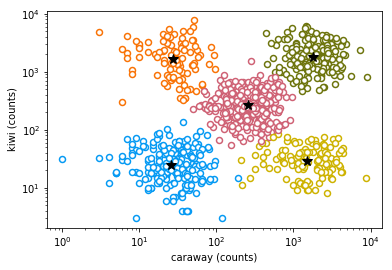

In [29]:
# visualizing the data
visualize_data(data, np.exp(np.array(centers_best)), clusters_best)

In [30]:
expr_levels(np.exp(centers_best), clusters_best)

,fraction,Caraway mean count,Kiwi mean count
0,0.097,27.289588,1624.901352
1,0.197,1796.308322,1824.829541
2,0.200,25.772877,24.517656
3,0.381,258.113885,262.434932
4,0.125,1501.942038,28.843558


We can see from above that (although out of order from Wiggins' code) the fractions of each cell cluster as well as their Caraway and Kiwi mean counts are similar to those of the true centroids, suggesting that taking the log of the data in the _k_-means clustering algorithm works as expected.